In [1]:
import os
import sys
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.signal as sig
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt

sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util
import plotutils as pu
import dsa


%matplotlib inline

In [2]:
configs = ["ns_3_mreg_1_msub_0_nf_32", "ns_3_mreg_2_msub_0_nf_32",
           "ns_3_mreg_3_msub_0_nf_32", "ns_3_mreg_4_msub_0_nf_32", "ns_3_mreg_5_msub_0_nf_32"]

conn = "linw"
preproc = "dicer"
modelname = "AB"

nconf = len(configs)

In [3]:
ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")
runs = [util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname, config, [0,1], "hcp") for config in configs]
direcs = [f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}" 
         for config, run in zip(configs, runs)]
paramss = [util.load_params(os.path.join(direc, "parameters"), range(0,100)) for direc in direcs]

In [4]:
nsub, nreg, _, nt = ds.y.shape
subjects = np.r_[:nsub]
regions = np.r_[:nreg]

In [5]:
runs

[0, 1, 0, 1, 0]

## Calculate KL

In [6]:
paramss[0].thetareg.shape

(100, 68, 1, 2)

In [7]:
nsamples = 10

maxmreg = 5
kl = np.full((nconf, nsub, nreg, maxmreg), np.nan)

for (iconf, isub, ireg) in itertools.product(range(nconf), range(nsub), range(nreg)):
    treg = paramss[iconf].thetareg[isub,ireg,:,:]
    mreg = treg.shape[0]

    tregmu  = treg[:,0]
    tregstd = treg[:,1]
    kl[iconf,isub,ireg,:mreg] = (np.log(1./tregstd) + (tregstd**2 + tregmu**2)/2. - 0.5)    

In [8]:
order = np.zeros((nconf, maxmreg), dtype=int)
for iconf in range(nconf):    
    order[iconf,:] = np.argsort(np.mean(-kl[iconf,:,:,:], axis=(0,1)))

In [9]:
order[2]

array([0, 1, 2, 3, 4])

In [10]:
print("   mreg=1   mreg=2   mreg=3   mreg=4   mreg=5")
print("---------------------------------------------")

for j in range(maxmreg):
    # print("  ", end='')
    for i in range(nconf): 
        if not np.isnan(np.mean(kl[i,:,:,order[i,j]])):
            print(f"& {np.mean(kl[i,:,:,order[i,j]]):6.3f} \\pm {np.std(kl[i,:,:,order[i,j]]):6.3f} ", end='')
        else:
            print("&         -         ", end='')
    print(" \\\\")

   mreg=1   mreg=2   mreg=3   mreg=4   mreg=5
---------------------------------------------
&  3.313 \pm  0.268 &  2.946 \pm  0.209 &  2.703 \pm  0.375 &  2.744 \pm  0.230 &  2.716 \pm  0.133  \\
&         -         &  2.266 \pm  0.935 &  2.107 \pm  0.546 &  2.238 \pm  0.754 &  2.048 \pm  0.714  \\
&         -         &         -         &  0.666 \pm  0.544 &  0.713 \pm  0.601 &  0.881 \pm  0.515  \\
&         -         &         -         &         -         &  0.002 \pm  0.002 &  0.004 \pm  0.007  \\
&         -         &         -         &         -         &         -         &  0.001 \pm  0.000  \\


## Plot the effect

In [11]:
iconf = 2

config = configs[iconf]
run = runs[iconf]
mreg = paramss[iconf].thetareg.shape[2]
order = np.argsort(np.mean(-kl[iconf,:,:,:], axis=(0,1)))[:mreg]

model = util.get_model(modelname, config, ds)
model.load_weights(f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}/fit/model")

2022-08-31 18:44:51.191999: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 18:44:51.227279: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3399905000 Hz
2022-08-31 18:44:51.228364: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55884a0b2e90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-31 18:44:51.228425: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-31 18:44:51.228625: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
def simulate(x0, eta, etaobs, u, us, treg, tsub):
    # Set the dimensions: (nsamples, m)
    x0 = x0[None,:]
    treg = treg[None,:]
    tsub = tsub[None,:]

    # Set the dimensions: (nsamples, nt, 1)
    u = u[None,:,None]
    us = us[None,:,None]

    eta = eta[None,:,:]

    x = model.source_model.simulate(x0, eta, u, us, treg, tsub, nt).numpy()
    y = (np.tensordot(x[0], model.Ap.numpy(), axes=[[1],[1]])[:,0] 
             + model.bp.numpy() + np.exp(0.5 * model.olv)*etaobs)
    
    return x[0].T, y

In [13]:
order

array([0, 1, 2])

## Simulate 

In [14]:
def get_us(model, n, nt):
    sig_p = 1.0
    alpha = np.exp(-1./np.exp(model.logtau.numpy()))
    sig_s = sig_p * np.sqrt(1 - alpha**2)
    us_samples = np.zeros((n, nt))
    us_samples[:,0] = np.random.normal(0, sig_p, size=n)
    eta_s = np.random.normal(0, sig_s, size=(n, nt))
    for i in range(nt-1):
        us_samples[:,i+1] = alpha*us_samples[:,i] + eta_s[:,i+1]
    return us_samples


def simulate_many():
    np.random.seed(42)

    nsamples = 1000
    T = 0.720
    freq_boundary = 0.1

    u_all  = ndsv.get_network_input_obs(ds.w[:], ds.y[:], comp=0).reshape((nsub*nreg, nt))
    us_all = get_us(model, nsamples, nt)

    # Choose the input to be constant at 80 percentile
    pwr = np.sum(u_all**2, axis=1)
    inds = np.where(pwr > np.percentile(pwr, 80))[0]
    u = u_all[inds[np.argmin(pwr[inds])]]
    uzero = np.zeros_like(u)

    t = np.linspace(0, nt, nt)
    ntd = int(nt/3)

    rows = []    

    for i in range(nsamples):
        if (i % 100 == 0):
            print(i, end=' ', flush=True)

        x0 = np.random.normal(0,1, size=model.ns)
        treg = np.random.normal(0, 1, size=(model.mreg))
        tsub = np.zeros(1)
        us = us_all[i]
        eta = np.random.normal(0, 1, size=(nt, model.ns))
        etaobs = np.random.normal(0, 1, size=(nt))

        _, y1 = simulate(x0, eta, etaobs, uzero, us, treg, tsub)
        _, y2 = simulate(x0, eta, etaobs, u, us, treg, tsub)

        # Time frequency analysis
        freqs, psd = sig.welch(y1[ntd:], 1/T, scaling='density', nperseg=128)
        low_freq = (freqs < freq_boundary)

        rows.append(dict(isample=i,
                         treg0=treg[0],
                         treg1=treg[1],
                         treg2=treg[2],
                         cc_u= np.corrcoef(y2[ntd:], u[ntd:])[1,0],
                         cc_us=np.corrcoef(y2[ntd:], us[ntd:])[1,0],
                         power_low = np.sum(psd[low_freq])
                        ))

    df = pd.DataFrame(rows)
    return df

In [15]:
df = simulate_many()

0 100 200 300 400 500 600 700 800 900 

In [16]:
# Multivariate regression
def norm(x):
    return (x - np.mean(x)) / np.std(x)

weights = np.zeros((3,3))
pvals = np.zeros((3,3))

for i, var in enumerate(['power_low', 'cc_us', 'cc_u']):
    ols = sm.OLS(norm(df[var]), sm.add_constant(df[['treg0', 'treg1', 'treg2']], prepend=False))
    res = ols.fit()
    weights[i,:] = res.params[:3]
    pvals[i,:] = res.pvalues[:3]

In [17]:
weights, pvals

(array([[-0.83098317, -0.04267631, -0.09946594],
        [-0.12094858,  0.87661117, -0.04953201],
        [ 0.68873501,  0.04118754,  0.50321259]]),
 array([[7.36532190e-260, 1.14076888e-002, 2.04169752e-008],
        [1.08512945e-021, 0.00000000e+000, 7.79314664e-005],
        [1.82984549e-216, 1.13267041e-002, 3.92622674e-139]]))

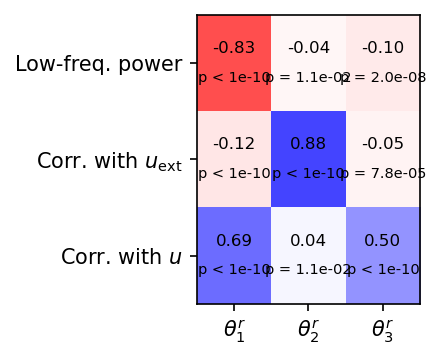

In [18]:
plt.figure(figsize=(3., 2.5), dpi=150)

plt.imshow(weights, cmap='bwr_r', vmin=-1.2, vmax=1.2, aspect='auto')
for i in range(3):
    for j in range(3):
        pvaltext = f"p = {pvals[i,j]:.1e}" if pvals[i,j] > 1e-10 else "p < 1e-10"
        # plt.text(j, i, f"{weights[i,j]:.2f}\n{pvaltext}", ha='center', va='center', fontsize=8)
        plt.text(j, i-0.15, f"{weights[i,j]:.2f}", ha='center', va='center', fontsize=8)
        plt.text(j, i+0.15, f"{pvaltext}",         ha='center', va='center', fontsize=7)

plt.xticks([0,1,2], [f"$\\theta^r_{i}$" for i in range(1,4)])
plt.yticks([0,1,2], ["Low-freq. power", r"Corr. with $u_\mathrm{ext}$", r"Corr. with $u$"]);

plt.tight_layout()
plt.savefig("./img/Fig_HCP-gen-multivar.pdf")

In [19]:
# Direction for the third panel
ols = sm.OLS(norm(df.cc_u), sm.add_constant(df[['treg0', 'treg2']], prepend=False))
res = ols.fit()
d = res.params[:2].to_numpy()

## Simulate the examples

In [20]:
# Simulate examples

np.random.seed(42)
n = 5

x0 = 0*np.ones(model.ns)
eta = np.random.normal(0, 1, size=(nt, model.ns))
etaobs = np.random.normal(0, 1, size=(nt))

t = np.linspace(0,1200,1200)
u_zero  = np.zeros(nt)
us_zero = np.zeros(nt)
u_sin   = 2*np.sin(0.4*t/(2*np.pi))
us_sin  = 2*np.sin(0.4*t/(2*np.pi))
    

tregs = np.zeros((mreg, n, mreg))       
tregs[0,:,order[0]] = np.linspace(-3,3,n)
tregs[1,:,order[1]] = np.linspace(-3,3,n)
tregs[2,:,order[2]] = np.linspace(-3,3,n)
   
tsub = np.array([0])
    
ys = np.zeros((mreg, n, nt))
    
for i in range(n):
    _, ys[0,i,:] = simulate(x0, eta, etaobs, u_zero, us_zero, tregs[0,i], tsub)   
    _, ys[1,i,:] = simulate(x0, eta, etaobs, u_zero, us_sin, tregs[1,i], tsub)
    _, ys[2,i,:] = simulate(x0, eta, etaobs, u_sin, us_zero, tregs[2,i], tsub)
    
    # for j in range(3):
    #     _, ys[j,i,:] = simulate(x0, eta, etaobs, u_zero, us_sin, tregs[j,i], tsub)

## Plotting

In [21]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [22]:
def plot_parampoints(ax, x):
    plt.sca(ax)
    ax.scatter(x[:,0], x[:,1], x[:,2], c=np.r_[:x.shape[0]], cmap='viridis', vmin=0, vmax=x.shape[0],
               alpha=1., s=20)
    ax.plot([-4, 4], [0,0], [0,0], color='k', lw=0.5)
    ax.plot([0,0], [-4,4], [0,0], color='k', lw=0.5)
    ax.plot([0,0], [0,0], [-4,4], color='k', lw=0.5)
    ax.set_axis_off()
    
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-2,2])
    
    ax.text(4,0,0, r"$\theta^r_1$")
    ax.text(0,4,0, r"$\theta^r_2$")
    ax.text(0,0,4, r"$\theta^r_3$")

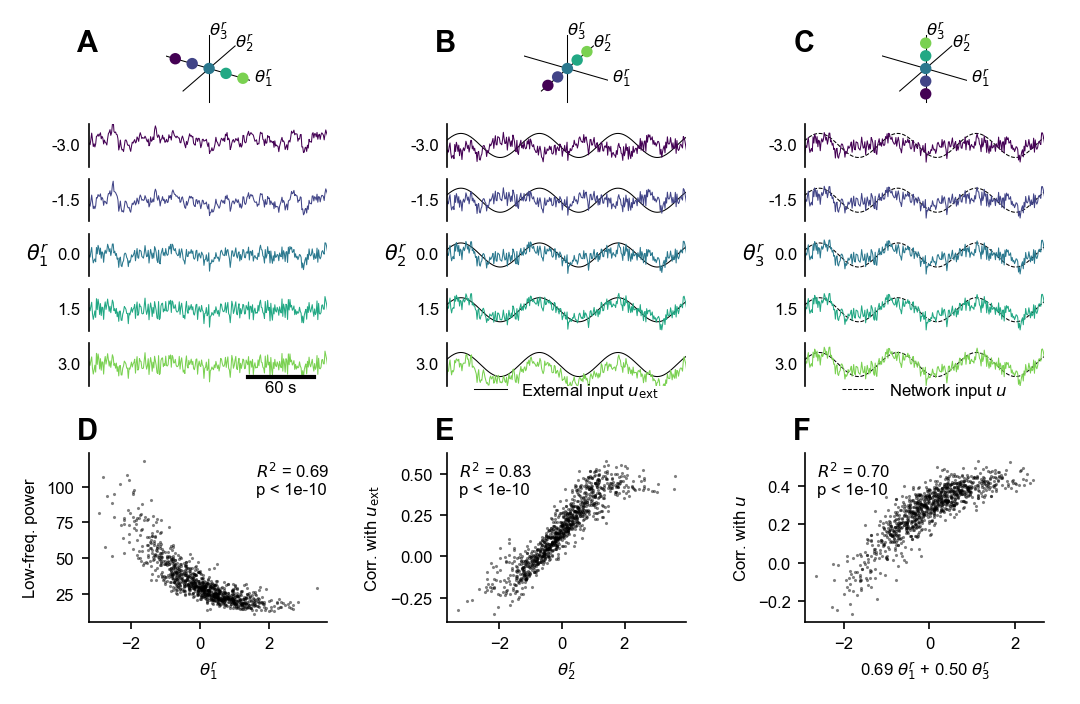

In [23]:
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=n)

fig = plt.figure(figsize=(7, 4.5), dpi=150)

gs = matplotlib.gridspec.GridSpec(8, 3, hspace=0.2, wspace=0.5, left=0.07, right=0.98, bottom=0.1, top=0.98,
                                 height_ratios=[2,1,1,1,1,1,1, 4])

for i in range(3):
    ax = fig.add_subplot(gs[0,i], projection='3d', proj_type='ortho')
    plot_parampoints(ax, tregs[i][:,order])
    

axes = []
for i in range(3):
    for j in range(n):
        ax = plt.subplot(gs[j+1,i])
        plt.plot(ys[i,j,:], color=cmap(norm(j)), lw=0.5)
        
        if i == 1:
            plt.plot(us_sin, color='k', lw=0.5, zorder=-1, label=r"External input $u_\mathrm{ext}$")
        if i == 2:
            plt.plot(u_sin, color='k', ls='--', lw=0.5, zorder=-2, label="Network input $u$")
        
        
        plt.xlim(500,800)
                
        plt.ylim(-3.5,3.5)
        plt.yticks([])        
        plt.text(490, 0, f"{tregs[i,j,order[i]]:.1f}", fontsize=8, ha='right', va='center')
        
        if j == 2:
            plt.text(450, 0, f"$\\theta^r_{i+1}$", fontsize=10, ha='right', va='center')
        
        plt.xticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        if i in [1,2] and j == n-1:
            plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.7), frameon=False)
            
        if j == 0:
            axes.append(ax)
            
        if i == 0 and j == n-1:
            dt = ds.t[1]-ds.t[0]
            nn = 60./dt
            plt.plot([700,700+nn], [-2,-2], lw=2, color='k')
            plt.text(700+nn/2, -2.6, "60 s", ha='center', va='top', fontsize=8)
            
            
ax = plt.subplot(gs[7,0])    
plt.scatter(df.treg0, df.power_low, s=0.25, color='k', alpha=0.5)
plt.xlabel(r"$\theta^r_1$")
plt.ylabel("Low-freq. power")
a, b, r, p, se = stats.linregress(df.treg0, df.power_low)
ptext = "p < 1e-10" if p < 1e-10 else f"p = {p}:e"
plt.text(0.7, 0.85, f"$R^2$ = {r**2:.2f}\n{ptext}", ha='left', va='center', transform=plt.gca().transAxes)
pu.bottomleft_spines(ax)
axes.append(ax)


ax = plt.subplot(gs[7,1])
plt.scatter(df.treg1, df.cc_us, s=0.25, color='k', alpha=0.5)
plt.xlabel(r"$\theta^r_2$")
plt.ylabel(r"Corr. with $u_\mathrm{ext}$")
a, b, r, p, se = stats.linregress(df.treg1, df.cc_us)
ptext = "p < 1e-10" if p < 1e-10 else f"p = {p}:e"
plt.text(0.05, 0.85, f"$R^2$ = {r**2:.2f}\n{ptext}", ha='left', va='center', transform=plt.gca().transAxes)
pu.bottomleft_spines(ax)
axes.append(ax)


ax = plt.subplot(gs[7,2])
plt.scatter(d[0]*df.treg0 + d[1]*df.treg2, df.cc_u, s=0.25, color='k', alpha=0.5)
plt.xlabel(f"{d[0]:.2f} $\\theta^r_1$ + {d[1]:.2f} $\\theta^r_3$")
plt.ylabel(r"Corr. with $u$")
a, b, r, p, se = stats.linregress(df.treg0+df.treg2, df.cc_u)
ptext = "p < 1e-10" if p < 1e-10 else f"p = {p}:e"
plt.text(0.05, 0.85, f"$R^2$ = {r**2:.2f}\n{ptext}", ha='left', va='center', transform=plt.gca().transAxes)    
pu.bottomleft_spines(ax)
axes.append(ax)
    
    
pu.Background(visible=False)
pu.add_panel_labels(fig, axes, xs=-0.05, ys=[2.6,2.6,2.6,1.05, 1.05, 1.05], fontsize=14)
plt.savefig("./img/Fig_ParamEffect.pdf")

## Additional figure for eigenvalues and derivatives

In [24]:
@tf.function
def calc_dfdu(x, treg, tsub, u, us):
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as g:
        g.watch(u)
        xaug = tf.concat([x, treg, tsub, u, us], axis=0)
        fx = model.source_model.f(xaug[None,:])[0]
    d = g.jacobian(fx, u)[:,0]
    return d


@tf.function
def calc_dfdus(x, treg, tsub, u, us):
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as g:
        g.watch(us)
        xaug = tf.concat([x, treg, tsub, u, us], axis=0)
        fx = model.source_model.f(xaug[None,:])[0]
    d = g.jacobian(fx, us)[:,0]
    return d


def rot_matrix(a, b):
    "Rotation matrix in 3D, aligning a to b"    
    
    a /= np.linalg.norm(a)
    b /= np.linalg.norm(b)
    
    if np.linalg.norm(a - b) < 1e-10:
        return np.eye(3)
    
    c = np.dot(a, b)    
    s = np.linalg.norm(np.cross(a, b))
    
    g = np.array([[c, -s, 0],
                  [s,  c, 0],
                  [0,  0, 1]])
    
    u = a
    v = b - c*a / np.linalg.norm(b - c*a)
    w = np.cross(b, a)
        
    finv = np.array([u, v, w])
    
    rot = np.linalg.inv(finv) @ g @ finv    
    
    return rot


def get_eigvals(treg, nsamples, vec):
    npoints = len(treg)

    thetareg = np.repeat(np.random.uniform(-2,2, (nsamples,1,model.mreg)), npoints, axis=1)
    thetareg[:,:,0] = treg    
    thetareg = np.einsum('ij,klj->kli', rot_matrix((1,0,0), vec), thetareg)
    
    thetasub = np.zeros(1)
    u  = np.random.uniform(-1.5, 1.5, nsamples)
    us = np.random.uniform(-1.5, 1.5, nsamples)

    eigvals = np.zeros((nsamples, npoints, model.mreg), dtype='complex')

    print("Eigvals: ", end='')
    for i in range(nsamples):
        print(i, end=' ', flush=True)
        for j in range(npoints):
            ev = dsa.find_fixed_points_node(model, thetareg[i,j,:], thetasub, u=u[i], us=us[i],
                                            init='random', n=5, init_range=(-2,2), threshold=1e-4)[2]
                
            if len(ev) == 0: eigvals[i,j] = np.nan
            else:            eigvals[i,j] = ev[0]
            
    return eigvals


def get_dfdus(treg, nsamples, vec):
    x = np.random.uniform(-2, 2, (nsamples, model.ns))
    u  = np.random.uniform(-2, 2, (nsamples, 1))
    us = np.random.uniform(-2, 2, (nsamples, 1))
    thetasub = np.zeros(1)
    
    # df/dus
    thetareg = np.repeat(np.random.uniform(-2,2, (nsamples,1,model.mreg)), npoints, axis=1)
    thetareg[:,:,0] = treg
    thetareg = np.einsum('ij,klj->kli', rot_matrix((1,0,0), vec), thetareg)
    
    dfdus = np.zeros((nsamples, npoints, model.ns))

    for i in range(nsamples):
        for j in range(npoints):
            dfdus[i,j] = calc_dfdus(x[i], thetareg[i,j], thetasub, u[i], us[i]).numpy()
            
    return dfdus


def get_dfdu(treg, nsamples, vec):
    x = np.random.uniform(-2, 2, (nsamples, model.ns))
    u  = np.random.uniform(-2, 2, (nsamples, 1))
    us = np.random.uniform(-2, 2, (nsamples, 1))
    thetasub = np.zeros(1)
    
    thetareg = np.repeat(np.random.uniform(-2,2, (nsamples,1,model.mreg)), npoints, axis=1)
    thetareg[:,:,0] = treg
    thetareg = np.einsum('ij,klj->kli', rot_matrix((1,0,0), vec), thetareg)
    
    dfdu = np.zeros((nsamples, npoints, model.ns))

    for i in range(nsamples):
        for j in range(npoints):
            dfdu[i,j] = calc_dfdu(x[i], thetareg[i,j], thetasub, u[i], us[i]).numpy()
        
    return dfdu

In [25]:
np.random.seed(42)        

nsamples = 51
npoints = 31       

treg = np.linspace(-3,3,npoints)

eigvals = get_eigvals(treg, nsamples, (1,0,0))
dfdus = get_dfdus(treg, nsamples, (0,1,0))
dfdu = get_dfdu(treg, nsamples, (d[0], 0, d[1]))

Eigvals: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

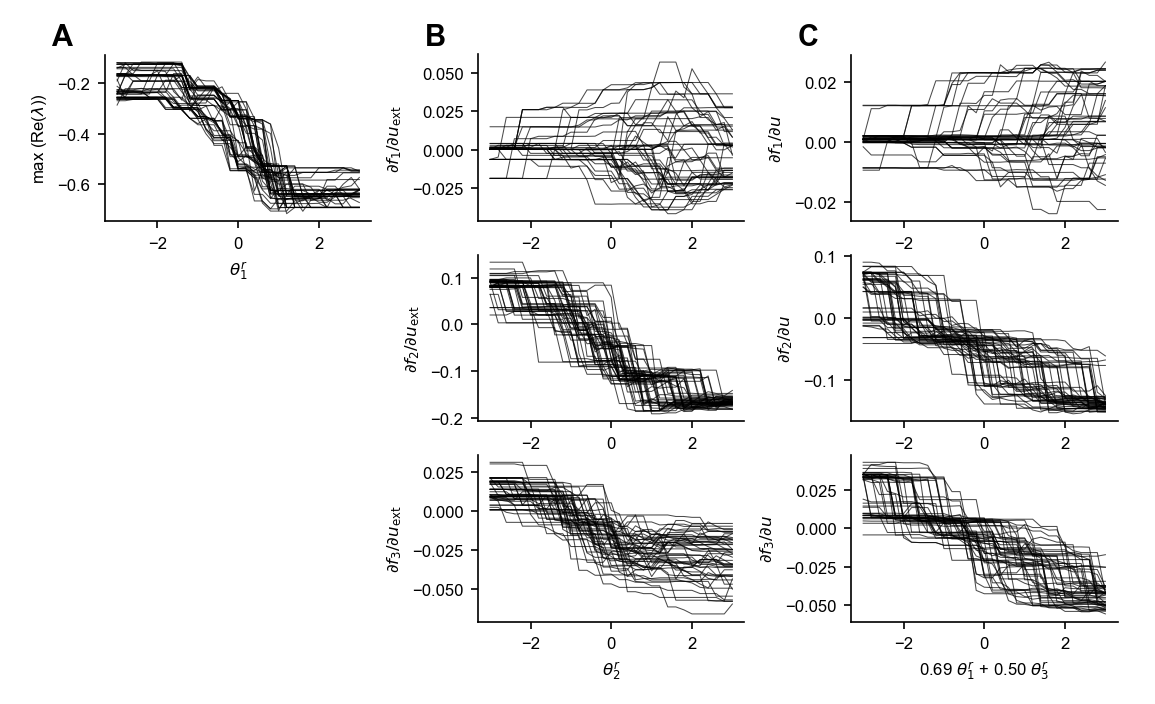

In [33]:
plt.figure(figsize=(7.5, 4.5), dpi=150)
gs = matplotlib.gridspec.GridSpec(nrows=3, ncols=3, left=0.08, right=0.98, bottom=0.1, top=0.94, wspace=0.4)

axes = []


ax = plt.subplot(gs[0,0])
for i in range(nsamples):
    plt.plot(treg, np.max(eigvals[i,:].real, axis=1), color='k', lw=0.5, alpha=0.7)
plt.ylabel(r"max (Re($\lambda$))")
plt.xlabel(r"$\theta^r_1$")
pu.bottomleft_spines(ax)
axes.append(ax)


for j in range(3):
    ax = plt.subplot(gs[j,1])
    for i in range(nsamples):
        plt.plot(treg, dfdus[i,:,j], color='k', lw=0.5, alpha=0.7)
        
    if j == 2:
        plt.xlabel(r"$\theta^r_{2}$")
    plt.ylabel(f"$\\partial f_{j+1} / \\partial u_\\mathrm{{ext}}$")
    pu.bottomleft_spines(ax)
    if j == 0:
        axes.append(ax)
    

    ax = plt.subplot(gs[j,2])
    for i in range(nsamples):
        plt.plot(treg, dfdu[i,:,j], color='k', lw=0.5, alpha=0.7)
        
    if j == 2:    
        plt.xlabel(f"{d[0]:.2f} $\\theta^r_1$ + {d[1]:.2f} $\\theta^r_3$")
    plt.ylabel(f"$\\partial f_{j+1} / \\partial u$")
    pu.bottomleft_spines(ax)
    if j == 0:
        axes.append(ax)
        


pu.add_panel_labels(axes=axes, xs=-0.2, ys=1.02, fontsize=14)
bg = pu.Background(visible=False)
plt.savefig("img/Fig_ParamEffectDS.pdf")